
### Analysis of LFADS input timing 

This is an examination of when LFADS controller outputs occur. As shown below, the inputs are sparse in time, and so the goal is to determine when the sharp peaks occur

TODO: measures of sparsity of the inputs

As is evident from the plots, peaks in the controller outputs tend to occur immediately after target appearances. The following is a distribution of latencies between taret appearances and the next peak, for peaks which occur within 500ms of a target appearance. I'll use a range of thresholds for peak appearances.

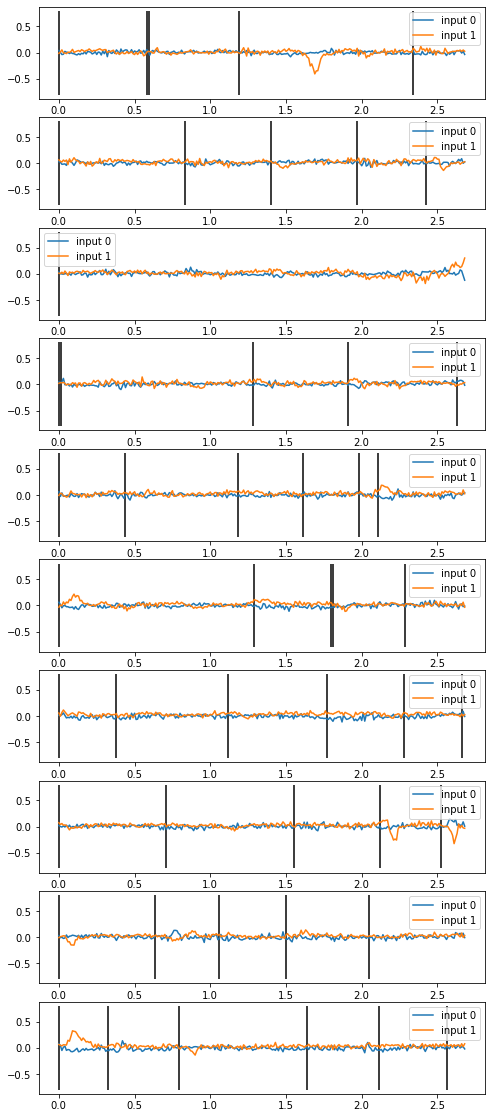

In [1]:
from scipy.io import loadmat
import sys
import h5py
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

trial_type = 'all'

sparse_filename = "/home/pmalonis/lfads_analysis/data/model_output/mk08011M1m_mack_RTP_2OLS24_all.h5"
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/mk08011M1m_mack_RTP.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/mk08011M1m_mack_RTP_inputInfo.mat"

input_info = loadmat(inputInfo_filename)
used_inds = utils.get_indices(input_info, trial_type)

df = pd.read_pickle(data_filename)

ntrials = 10
with h5py.File(sparse_filename) as h5file:
    trial_len_ms = input_info['seq_timeVector'][-1][-1]
    dt = np.round(trial_len_ms/h5file['controller_outputs'].shape[1])/1000 
    trial_len = trial_len_ms/1000
    trial_len = np.floor(trial_len/dt)*dt
    lfads_t = np.arange(0, trial_len, dt)
    plt.figure(figsize=(8,20))
    for i, trial_idx in enumerate(used_inds[100:100+ntrials]):
        plt.subplot(ntrials, 1, i + 1)
        n_inputs = h5file['controller_outputs'].shape[2]
        targets = df.loc[trial_idx].kinematic.loc[:trial_len].query('hit_target').index.values
        plt.vlines(targets, -.8,.8)
        legend = []
        for input_idx in range(n_inputs):
            plt.plot(lfads_t, h5file['controller_outputs'][i,:,input_idx])
            legend.append('input %d'%input_idx)

        plt.legend(legend)

In [2]:
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
import timing_analysis as ta
import segment_submovements as ss
import seaborn as sns
from scipy import io
import utils
import importlib
import pandas as pd
import h5py
import utils
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(ta)
importlib.reload(ss)
importlib.reload(utils)

trial_type = 'all'
#lfads_filename = "/home/pmalonis/lfads_analysis/data/model_output/mk08011M1m_mack_RTP_2OLS24_all.h5"
lfads_filename = "/home/pmalonis/lfads_analysis/data/model_output/mk08011M1m_mack_RTP_uctZJw_all.h5"
data_filename = "/home/pmalonis/lfads_analysis/data/intermediate/mk08011M1m_mack_RTP.p"
inputInfo_filename = "/home/pmalonis/lfads_analysis/data/model_output/mk08011M1m_mack_RTP_inputInfo.mat"

#limits of window to look for peaks after target appearance
win_start = 0
win_stop = 0.5
# minimum distance between peaks
min_distance = 5

df = pd.read_pickle(data_filename)
input_info = io.loadmat(inputInfo_filename)
with h5py.File(lfads_filename, 'r') as h5file:
    co = h5file['controller_outputs'].value
    dt = utils.get_dt(h5file, input_info)
    trial_len = utils.get_trial_len(h5file, input_info)
    n_inputs = h5file['controller_outputs'].shape[2]


/home/pmalonis/miniconda3/envs/lfads_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:33: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


In [3]:
importlib.reload(ta)
importlib.reload(ss)
importlib.reload(utils)
peak_thresholds = [.1, .2, .3, .4]
peak_dfs = []
for peak_thresh in peak_thresholds:   
    targets = ta.get_targets(df)
    peaks = ta.get_peaks(co, dt, peak_thresh, min_distance)
    target_peaks, peak_counts = ta.get_latencies(targets, peaks, win_start, win_stop, trial_len=trial_len)
    peak_dfs.append(target_peaks)

/home/pmalonis/lfads_analysis/src/timing_analysis.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_peaks.loc[trial_idx]['latency_%d'%input_idx].iloc[target_idx] = diff_targets[target_idx]


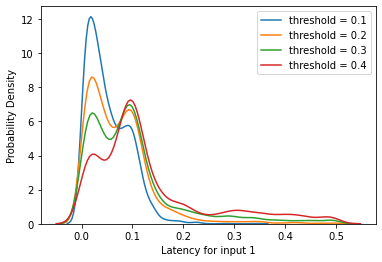

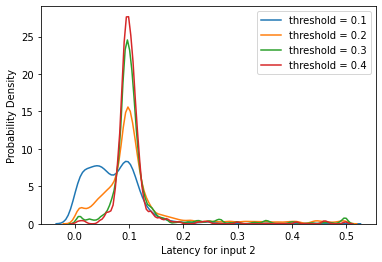

In [4]:
for i in range(n_inputs):
    plt.figure()
    for j, p in enumerate(peak_thresholds):
        label = 'threshold = %0.1f'%p
        sns.distplot(peak_dfs[j]['latency_%d'%i], 
                     hist=False, label=label)

    plt.legend()
    plt.xlabel('Latency for input %d'%(i+1))
    plt.ylabel('Probability Density')


Text(0.5, 1.0, 'Mack')

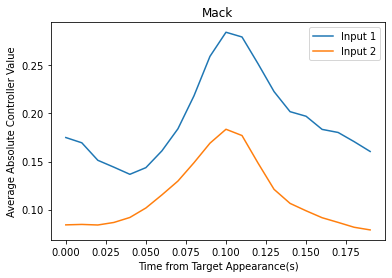

In [30]:
pkdf = peak_dfs[2]
window = 0.2
pkdf = pkdf.iloc[np.where(pkdf.index.get_level_values('time') < trial_len - window)]
ctrl_avg = np.zeros((co.shape[2],int(window/dt)))
for n, (trial, time) in enumerate(pkdf.index):
    idx_start = int(time/dt)
    idx_stop = int((time + window)/dt)
    ctrl_avg = (n/(n+1)) * ctrl_avg + np.abs(co[trial,idx_start:idx_stop,:].T)/(n+1)
    
t = np.arange(0, window, dt)
plt.plot(t,ctrl_avg[0])
plt.plot(t,ctrl_avg[1])
#plt.plot(t,ctrl_avg.mean(0))
plt.xlabel('Time from Target Appearance(s)')
plt.ylabel('Average Absolute Controller Value')
plt.legend(['Input 1', 'Input 2'])
plt.title('Mack')

In [26]:
co[0,:20,:].T

array([[ 0.23530288, -0.05189583],
       [ 0.315441  , -0.03093402],
       [ 0.31181732,  0.0090868 ],
       [ 0.2324051 ,  0.04927162],
       [ 0.23077674,  0.11039179],
       [ 0.16103153,  0.13268262],
       [ 0.34388465,  0.14853239],
       [ 0.04023036,  0.1161426 ],
       [ 0.2201365 ,  0.11593394],
       [ 0.46431834,  0.09056632],
       [-0.02870057,  0.06106634],
       [ 0.1710609 ,  0.04496743],
       [ 0.14701544,  0.06526136],
       [ 0.07582413,  0.03211681],
       [ 0.0831776 , -0.03387395],
       [ 0.17591809, -0.06032756],
       [ 0.42537415, -0.02925172],
       [-0.18596318, -0.02451642],
       [-0.00673255,  0.0053621 ],
       [ 0.04897402,  0.00060044]], dtype=float32)

In [5]:
total_targets = targets.shape[0]
inputs = list(range(n_inputs))
targets_with_peak = [ta.get_target_peak_counts(target_peaks, input_idx) for input_idx in inputs]
targets_any = ta.get_target_peak_counts(target_peaks, inputs, all_inputs=False)
targets_all = ta.get_target_peak_counts(target_peaks, inputs, all_inputs=True)

In [6]:
import matplotlib
bardf=pd.DataFrame({'input 1':[(peak_dfs[i].latency_0.notnull() & peak_dfs[i].latency_1.isnull()).sum() for i in range(len(peak_dfs))],
'input 2':[(peak_dfs[i].latency_1.notnull() & peak_dfs[i].latency_0.isnull()).sum() for i in range(len(peak_dfs))],
'both':[(peak_dfs[i].latency_1.notnull() & peak_dfs[i].latency_0.notnull()).sum() for i in range(len(peak_dfs))],
'neither':[(peak_dfs[i].latency_1.isnull() & peak_dfs[i].latency_0.isnull()).sum() for i in range(len(peak_dfs))]},
index=peak_thresholds)


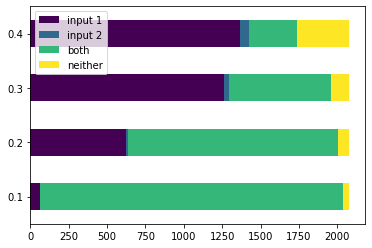

In [7]:

cmap = matplotlib.cm.get_cmap('viridis')
rgba = cmap(np.linspace(0,1,len(peak_thresholds)))
ax = bardf.plot.barh(stacked=True, color=rgba)
fig = ax.get_figure()


In [8]:
def get_directions(pkdf)
    x = pkdf.target_x-pkdf.x
    y = pkdf.target_y-pkdf.y
    np.

best_threshold = 0.3
i = peak_thresholds.index(best_threshold) #index of best threshold
peak_dfs[i]

SyntaxError: invalid syntax (<ipython-input-8-4e3570c5adc7>, line 1)

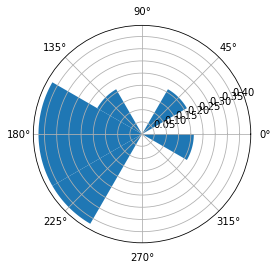

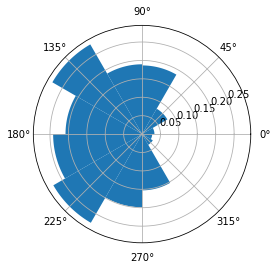

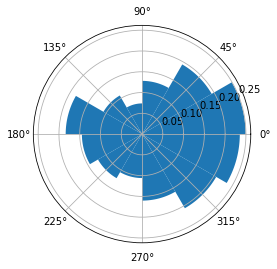

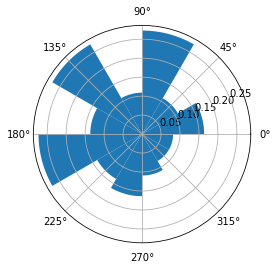

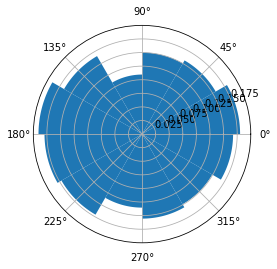

In [8]:
pkdf = peak_dfs[1]
x = pkdf.target_x-pkdf.x
y = pkdf.target_y-pkdf.y
theta=np.arctan2(y, x)[pkdf.latency_1.notnull() & pkdf.latency_0.isnull()].values
utils.polar_hist(theta, 12)
plt.figure()
theta=np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.isnull()].values
utils.polar_hist(theta, 12)
plt.figure()
theta=np.arctan2(y, x)[pkdf.latency_0.notnull() & pkdf.latency_1.notnull()].values
utils.polar_hist(theta, 12)
theta=np.arctan2(y, x)[pkdf.latency_0.isnull() & pkdf.latency_1.isnull()].values
plt.figure()
utils.polar_hist(theta, 12)
theta=np.arctan2(y, x)
plt.figure()
utils.polar_hist(theta, 12)

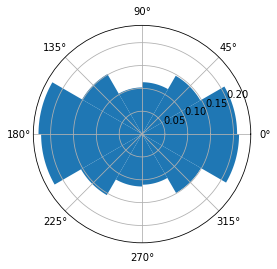

In [10]:
minx = np.min(peak_dfs[2].target_x.values)
maxx = np.max(peak_dfs[2].target_x.values)
miny = np.min(peak_dfs[2].target_y.values)
maxy = np.max(peak_dfs[2].target_y.values)

x = np.diff(np.random.rand(2,10000)*(maxx-minx) + minx, axis=0)
y = np.diff(np.random.rand(2,10000)*(maxy-miny) + miny, axis=0)

theta = np.arctan2(y,x)
utils.polar_hist(theta, 12)

In [1]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

pkdf['input'] = ''

pkdf.loc[pkdf.latency_0.notnull() & pkdf.latency_1.isnull(),'input'] = 'input_1'
pkdf.loc[pkdf.latency_0.isnull() & pkdf.latency_1.notnull(),'input'] = 'input_2'
pkdf.loc[pkdf.latency_0.notnull() & pkdf.latency_1.notnull(),'input'] = 'both'
pkdf.loc[pkdf.latency_0.isnull() & pkdf.latency_1.isnull(),'input'] = 'neither'


#model = RandomForestClassifier()
model = xgb.XGBClassifier()
#model = SVC(kernel='linear')

X = np.concatenate([pkdf[['target_x','target_y']], pkdf[['target_x', 'target_y']].values - pkdf[['x','y']].values], axis=1)
y = pkdf['input'].values
nan_rows = np.where(np.isnan(X))[0]
X = np.delete(X, nan_rows, axis=0)
y = np.delete(y, nan_rows, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X,y)
model.fit(X_train,y_train)
model.score(X_test, y_test)

NameError: name 'pkdf' is not defined

<Figure size 432x288 with 0 Axes>

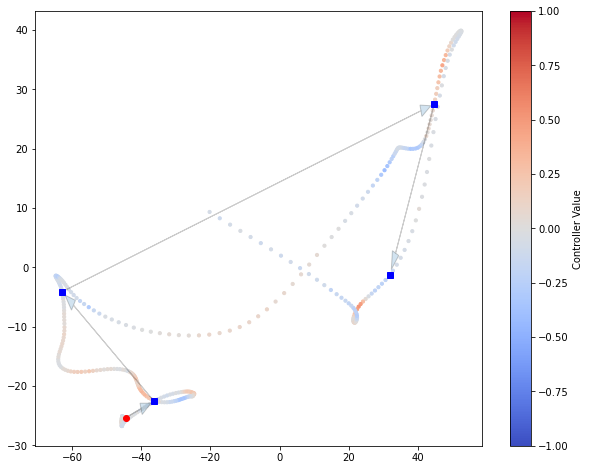

<Figure size 432x288 with 0 Axes>

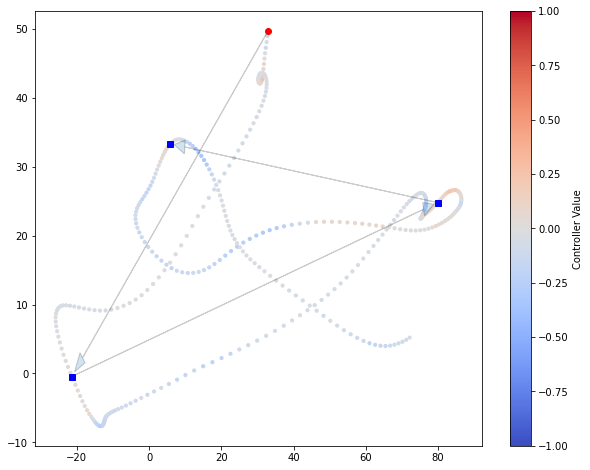

<Figure size 432x288 with 0 Axes>

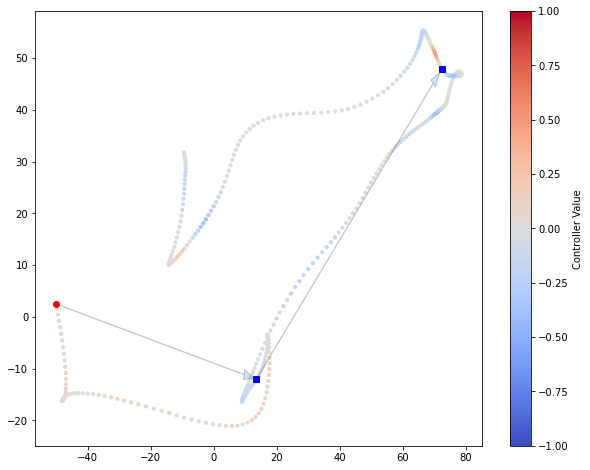

<Figure size 432x288 with 0 Axes>

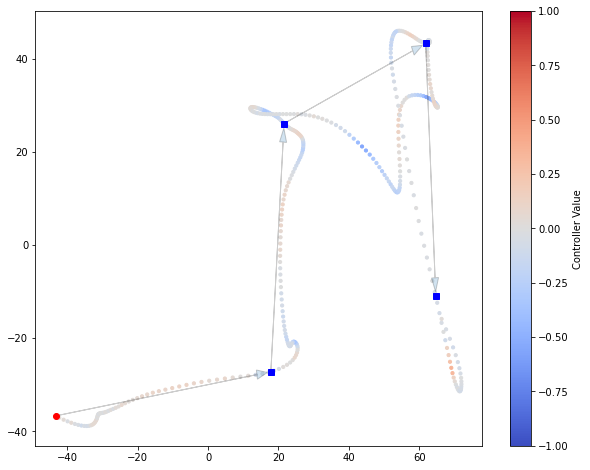

<Figure size 432x288 with 0 Axes>

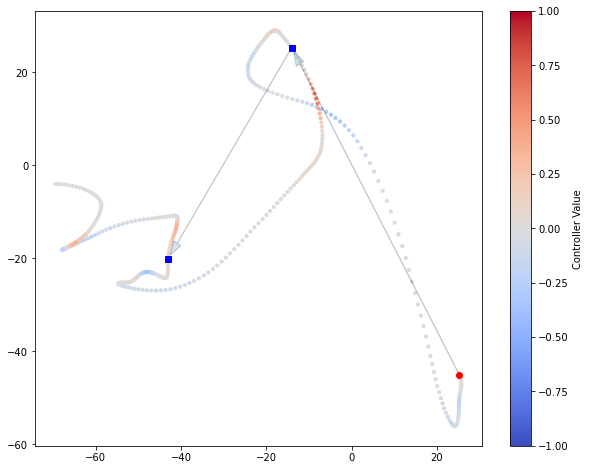

In [11]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = False
for i in range(100, 150, 10):
    plt.figure()
    ss.plot_trajectory_co(df.loc[i], co[i,:,0], dt)

In [4]:
import sys
sys.path.insert(0, '/home/pmalonis/lfads_analysis/src')
from power_law import get_curvature

n_trials = df.index[-1][0] + 1
K = []
trial_len = co.shape[1] * dt
for i in range(n_trials):
    trial_df = df.loc[i]
    t_target = trial_df.kinematic.query('hit_target').index
    idx = range(trial_df.shape[0])
    t = trial_df.index[idx]
    x = trial_df.kinematic['x'].iloc[idx].values
    y = trial_df.kinematic['y'].iloc[idx].values
    idx = [trial_df.index.get_loc(t, 'nearest') for t in np.arange(0, trial_len, dt)]
    K.append(get_curvature(x,y,t)[idx])
    
curv = np.concatenate(K)
#np.corrcoef(curv, co[:10,:,0].flatten())[0,1]

In [13]:
K_feedback = []
co_feedback = []
post_target_exclude = .25
post_target_win_size = int(post_target_exclude/dt)
for i in range(n_trials):
    targets = df.loc[i].kinematic.query('hit_target')[:trial_len].index.values
    target_dt = np.round(targets/dt).astype(int)
    target_dt = np.append(target_dt, trial_len/dt)
    intervals = [(int(tdt+post_target_win_size), int(target_dt[i+1])) for i,tdt in enumerate(target_dt[:-1])]
    for start,stop in intervals:
        K_feedback.append(K[i][start:stop])
        co_feedback.append(co[i,start:stop,0])

array([[ 1.        , -0.11088131],
       [-0.11088131,  1.        ]])

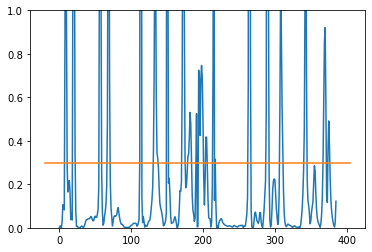

In [83]:
plt.plot(K[0])
plt.ylim([0, 1])
plt.plot(plt.xlim(), np.ones(2)*.3)

In [1]:
from numpy.linalg import norm
Ttrial = co.shape[1] #number of samples in single trial
m=co[:,:,0].mean()
nwin = 6 #half length of window to compute curvature in
#straight = np.concatenate([[norm(co[j,i-nwin:i+nwin,1]) for i in range(nwin,Ttrial-nwin) if np.all(K[j][i-nwin:i+nwin]<.1)] for j in range(n_trials)])
#curve = np.concatenate([[norm(co[j,i-nwin:i+nwin,1]) for i in range(nwin,Ttrial-nwin) if np.any(K[j][i-nwin:i+nwin]>.2)] for j in range(n_trials)])
straight = np.concatenate([[np.mean(np.abs(co_feedback[j][i-nwin:i+nwin])) for i in range(nwin,len(co_feedback[j])-nwin) if np.all(K_feedback[j][i-nwin:i+nwin]<.01)] for j in range(len(co_feedback))])
curve = np.concatenate([[np.mean(np.abs(co_feedback[j][i-nwin:i+nwin])) for i in range(nwin,len(co_feedback[j])-nwin) if np.any(K_feedback[j][i-nwin:i+nwin]>.3)] for j in range(len(co_feedback))])

NameError: name 'co' is not defined

0.5944949388504028
0.9008399844169617
13200
41203
MannwhitneyuResult(statistic=207886227.0, pvalue=0.0)


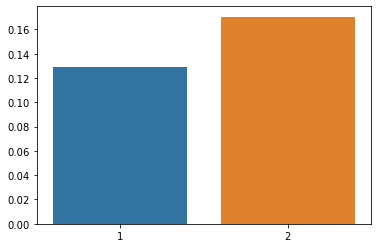

In [15]:
straight = straight[~np.isnan(straight)]
print(np.max(straight))
print(np.max(curve))
print(len(straight))
print(len(curve))

from scipy.stats import wilcoxon, mannwhitneyu
print(mannwhitneyu(straight, curve))
from seaborn import barplot
barplot([1, 2], [np.mean(straight), np.mean(curve)])

In [43]:
going=True
j=0
while going==True:
    if  np.all(K_feedback[j][i-nwin:i+nwin]<.01):
        going=False
    j+=1

range(nwin,Ttrial-nwin)

range(12, 374)

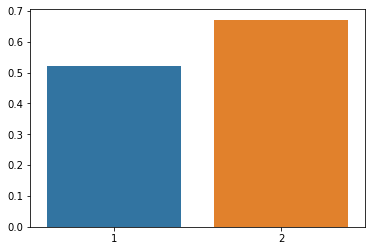

386